# Train consumption
### Road to undestanding and graphing by NEM0215

## Sources
> https://www.movable-type.co.uk/scripts/latlong.html

> https://boulter.com/gps/distance/?from=49.97212553+17.860912499&to=49.972125524+17.860912502&units=k

> https://pressbooks.bccampus.ca/physics0312chooge/chapter/2-4-acceleration/

> https://www.quora.com/How-do-you-find-final-velocity-from-acceleration-and-distance

> https://www.quora.com/How-do-I-calculate-the-final-velocity-based-on-distance-and-acceleration-with-the-initial-velocity-being-0-What-is-the-formula

> https://www.real-world-physics-problems.com/work-and-energy.html

> https://energyeducation.ca/encyclopedia/Energy_vs_power

> https://www.khanacademy.org/science/in-in-class11th-physics/in-in-class11th-physics-work-energy-and-power/in-in-class11-work-energy-theorem/a/work-energy-theorem-ap1

> https://en.wikipedia.org/wiki/Equations_of_motion#Uniform_acceleration

## Imports

In [1]:
import json
import math
import matplotlib.pyplot as plt

## Constants

In [2]:
G_TO_MS2 = 9.80665
TRAIN_ACC_G = 0.1
TRAIN_ACC_MS2 = TRAIN_ACC_G * G_TO_MS2
TRAIN_DEC_G = 0.12
TRAIN_DEC_MS2 = TRAIN_DEC_G * G_TO_MS2

## Functions

In [3]:
def parse_points_from_geojson(geojson_raw):
    geojson = json.loads(geojson_raw)
    return geojson["coordinates"]

In [4]:
# https://www.movable-type.co.uk/scripts/latlong.html
def calc_distance_two_points(point_a, point_b):
    R = 6371e3 # meters
    φ1 = point_a[1] * math.pi/180 # φ, λ in radians
    φ2 = point_b[1] * math.pi/180
    Δφ = (point_b[1]-point_a[1]) * math.pi/180
    Δλ = (point_b[0]-point_a[0]) * math.pi/180
    
    a = math.sin(Δφ/2) * math.sin(Δφ/2) + math.cos(φ1) * math.cos(φ2) * math.sin(Δλ/2) * math.sin(Δλ/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c # in meters

In [5]:
def calc_kinetic_energy(mass, velocity):
    return (mass*velocity**2)/2

In [6]:
def calc_velocity(acceleration, distance, init_velocity=0):
    return math.sqrt(init_velocity**2 + 2*acceleration*distance)

def calc_distance(acceleration, velocity, init_velocity=0):
    return (velocity**2-init_velocity**2)/(2*acceleration)

In [7]:
def get_deceleration(points, max_velocity, decimal_places=2):
    dist = 0
    end_velocity = [0]
    for i in range(len(points)-1,0,-1):
        dist_to_next = dist + calc_distance_two_points(points[i], points[i-1])
        while True:
            dist += 1/10**decimal_places
            velocity = calc_velocity(TRAIN_DEC_MS2, dist)
            if velocity >= max_velocity:
                break
            end_velocity.append(velocity)
    return end_velocity

def get_acceleration(points, max_velocity, decimal_places=2):   
    dist_values = [0]
    velocity_values = [0]
    dist = 0
    velocity_reached = False
    for i in range(len(points)-1):
        dist_to_next = dist + calc_distance_two_points(points[i], points[i+1])
        while True:
            dist += 1/10**decimal_places
            if not velocity_reached:
                velocity = calc_velocity(TRAIN_ACC_MS2, dist)
                if velocity >= max_velocity:
                    velocity = max_velocity
                    velocity_reached = True
            dist_values.append(dist)
            velocity_values.append(velocity)
            if dist >= dist_to_next:
                break
    return dist_values, velocity_values

def get_complete_velocity(points, max_velocity, decimal_places=2):
    dist_values, velocity_values = get_acceleration(points, max_velocity, decimal_places)
    end_velocity = get_deceleration(points, max_velocity, decimal_places)
    for i in range(len(end_velocity)):
        velocity_values[-i-1] = end_velocity[i]
    return dist_values, velocity_values

def get_energy(mass, velocity_values):
    return [calc_kinetic_energy(mass, x) for x in velocity_values]

def get_work(energy_values):
    return [energy_values[i+1]-x for i,x in enumerate(energy_values) if i < len(energy_values)-1]

In [8]:
def compile_plot(mass, points, max_velocity):
    dist = 0
    end_velocity = [0]
    for i in range(len(points)-1,0,-1):
        dist += calc_distance_two_points(points[i], points[i-1])
        velocity = calc_velocity(TRAIN_DEC_MS2, dist)
        if velocity >= max_velocity:
            break
        # end_dist.insert(0, dist)
        end_velocity.insert(0, velocity)
    
    len_points = len(points)
    len_dec = len(end_velocity)
    dist_values = [0]
    velocity_values = [0]
    energy_values = [0]
    work_values = [0]
    dist = 0
    kinetic_energy = 0
    velocity_reached = False
    for i in range(len_points-1):
        dist += calc_distance_two_points(points[i], points[i+1])
        # dist_delta = dist - dist_values[-1]
        # print(dist_delta, round(dist_delta, 2))
        work = kinetic_energy
        if i+1 > len_points-1-len_dec:
            j = i-(len_points-1-len_dec)
            velocity = end_velocity[j]
        elif not velocity_reached:
            velocity = calc_velocity(TRAIN_ACC_MS2, dist)
            if velocity >= max_velocity:
                velocity = max_velocity
                velocity_reached = True
        kinetic_energy = calc_kinetic_energy(mass, velocity)
        work = kinetic_energy - work
        
        dist_values.append(dist)
        velocity_values.append(velocity)
        energy_values.append(kinetic_energy)
        work_values.append(work)
    return dist_values, velocity_values, energy_values, work_values

In [9]:
def draw_plot(dist_values, **kwargs):
    fig=plt.figure(figsize=(20,4), dpi= 100)
    plt.xlabel("Vzdálenost (m)")
    # plt.ylabel("Rychlost (m/s)")
    for line in kwargs:
        plt.plot(dist_values, kwargs[line], label=line, marker="o")
    # plt.axhline(y=max_velocity, color="grey", linestyle="dotted", label="Rychlostní limit trati")
    plt.legend()
    plt.show()

## Testing velocity and reverse distance calculation

In [10]:
v = calc_velocity(TRAIN_ACC_MS2, 100, 10)
print(v)

dist = calc_distance(TRAIN_ACC_MS2, v, 10)
print(dist)

17.20851533398509
99.99999999999999


## Cobbled-together run:

[0, 29410.91236539798, 10012.675492307597, 19400.241742587685, 29409.460146083147, 29409.26921559444, 29405.794105623965, 29407.78677500825, 29410.657322125917, 29406.920937308198]


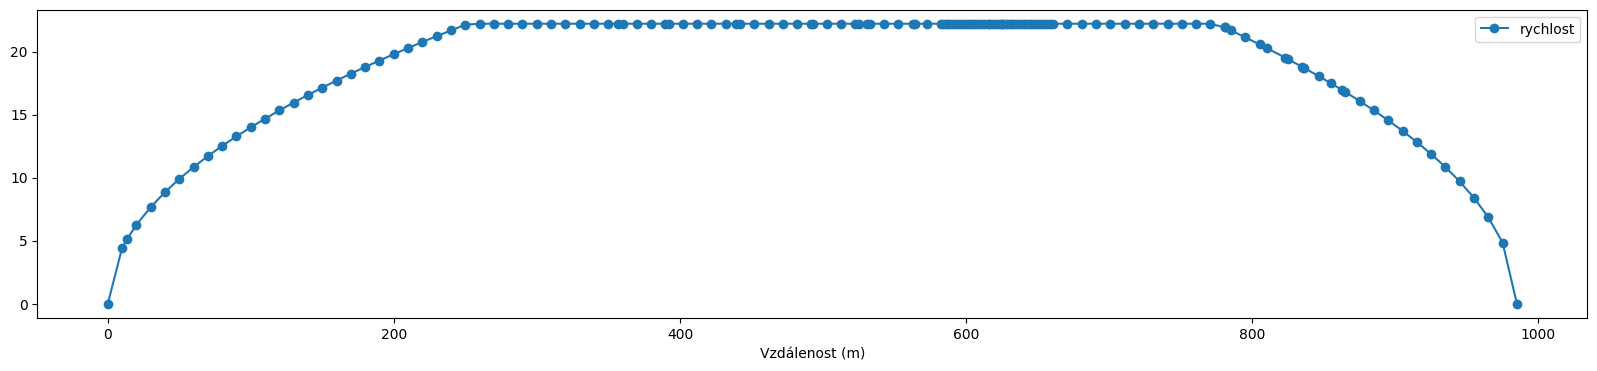

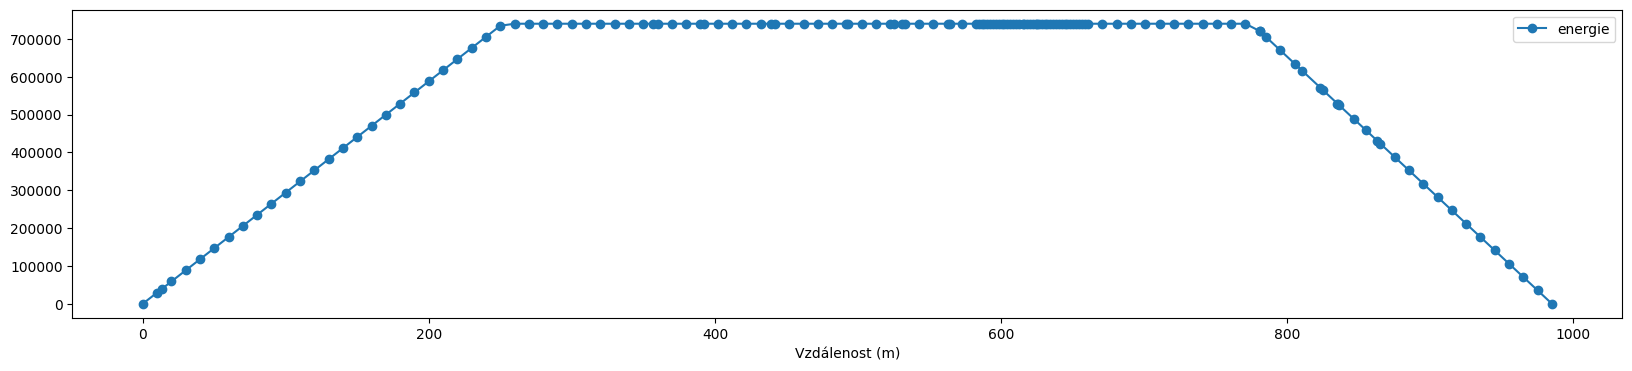

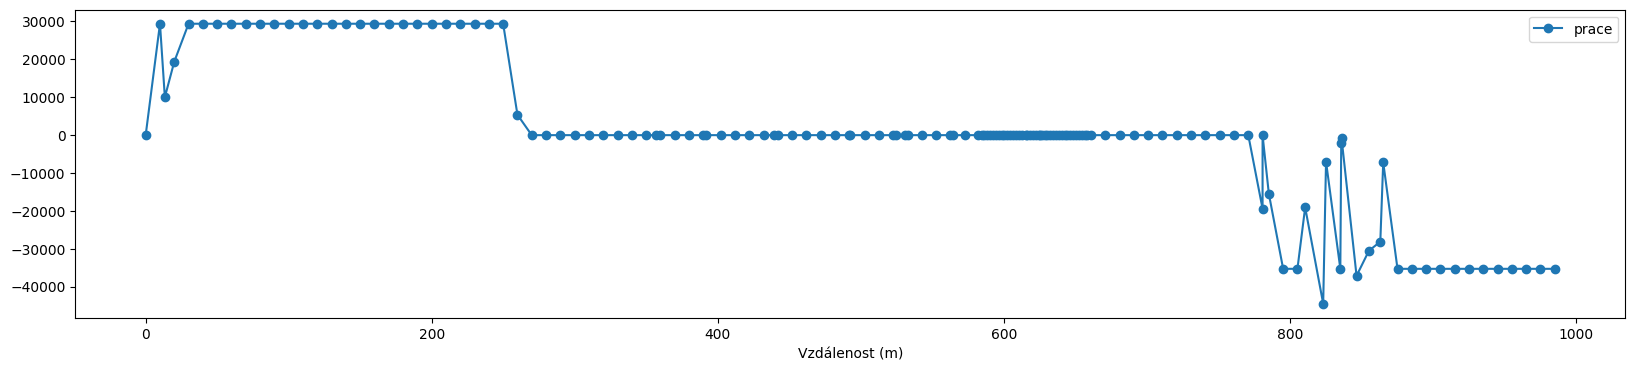

In [11]:
with open("/home/sawy/Plocha/Opava-Olomouc.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))

max_velocity = 22.22 # m/s
mass = 3000 # kg
dist_values, velocity_values, energy_values, work_values = compile_plot(mass, points, max_velocity)

# process_work(dist_values, work_values)
print(work_values[0:10])

draw_plot(dist_values, rychlost=velocity_values)
draw_plot(dist_values, energie=energy_values)
draw_plot(dist_values, prace=work_values)

## Cleaner approach

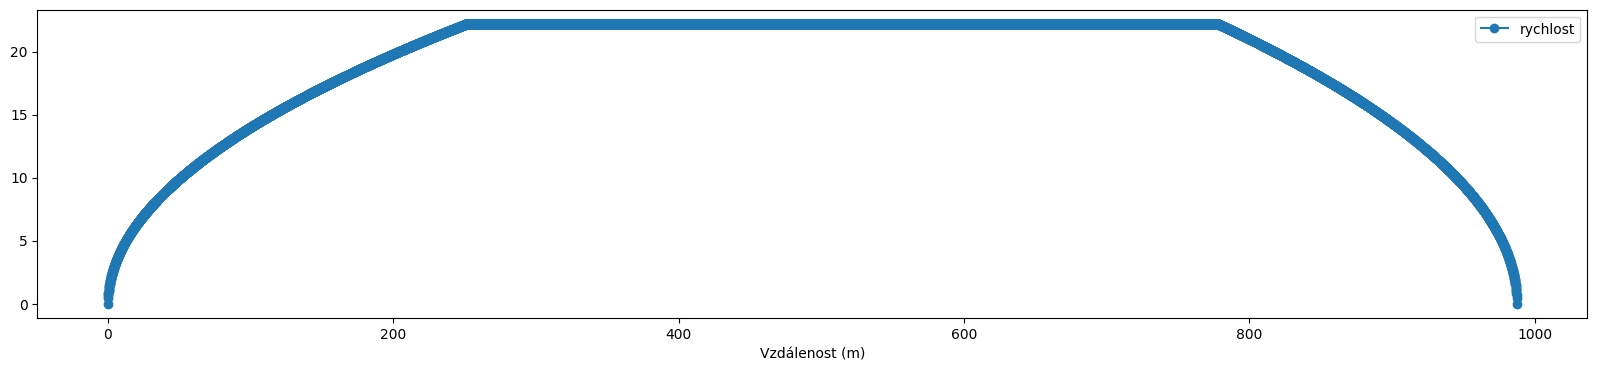

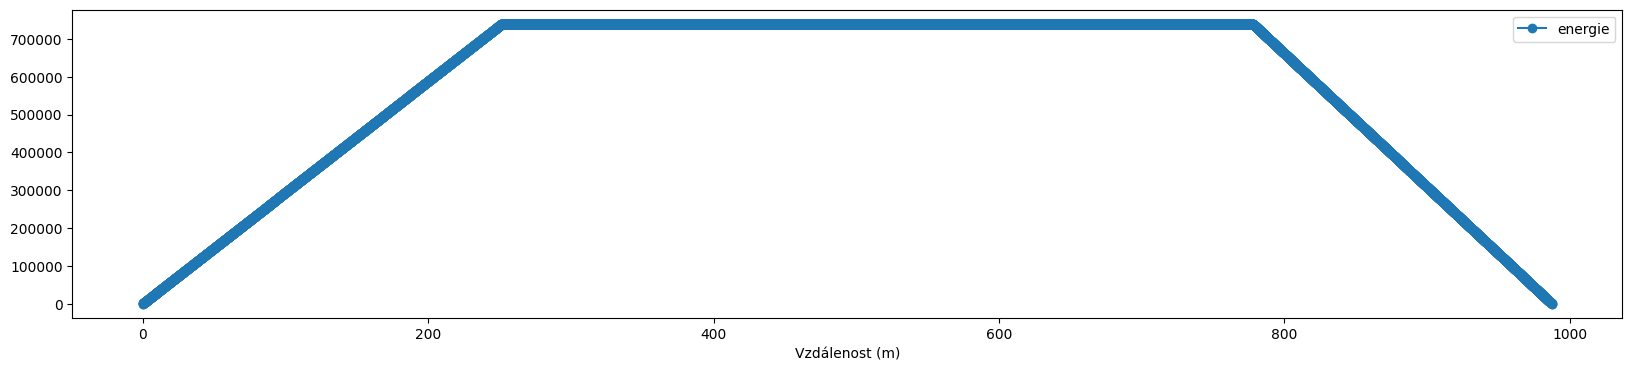

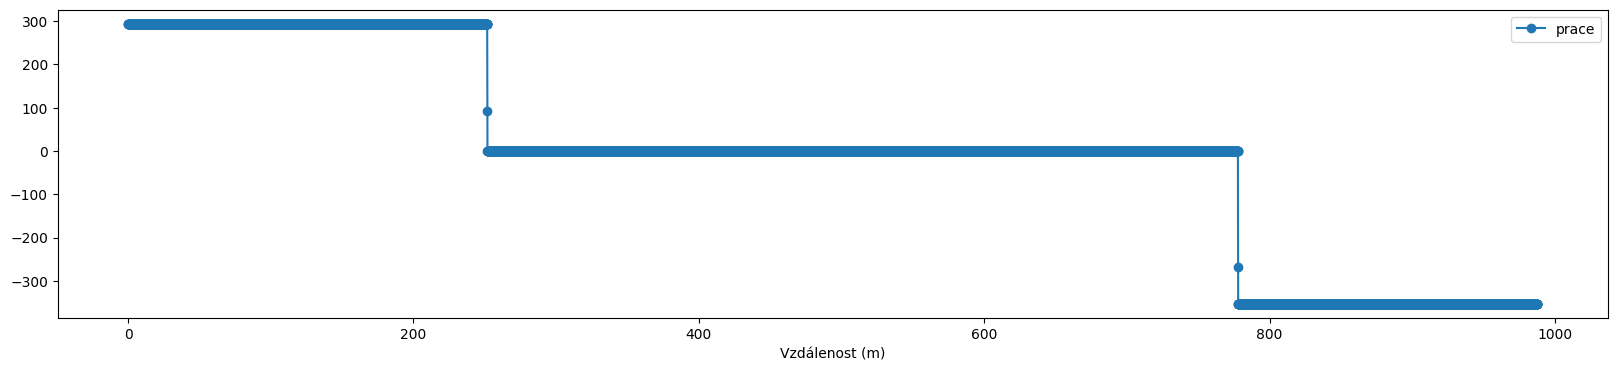

In [12]:
with open("/home/sawy/Plocha/Opava-Olomouc.geojson") as f:
    lines = f.readlines()
    points = parse_points_from_geojson("".join(lines))
    
max_velocity = 22.22 # m/s
mass = 3000 # kg
dist_values, velocity_values = get_complete_velocity(points, max_velocity, 1)
energy_values = get_energy(mass, velocity_values)
work_values = get_work(energy_values)

# Plots
draw_plot(dist_values, rychlost=velocity_values)
draw_plot(dist_values, energie=energy_values)
draw_plot(dist_values[1::], prace=work_values)